<a href="https://colab.research.google.com/github/MaOdRo/master_dual_encoder/blob/main/Einleitung_Datainspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wikipedia -Image/Caption Matching Competition

## 1. Einleitung


**Autor:** Marten Rogall<br>

Zur Einleitung soll hier ein Überblick über die verwendeten Datensätze gegeben werden. Außerdem wird im Folgenden kurz das Ziel der [Wikipedia -Image/Caption Matching Competition](https://www.kaggle.com/competitions/wikipedia-image-caption) und das Ziel meiner Masterarbeit beschrieben. Das Datenpreprocessing habe ich auf Grund der langen Dauer auf dieses [Kaggle-Notebook](https://www.kaggle.com/code/martenro/fork-of-preprocessedcaptionwikifeatherformat/notebook?scriptVersionId=92647710) ausgelagert.


---


Wie in der Grafik unten zu lesen, ist das Ziel der Wikipedia -Image/Caption Matching Competition ein Modell zu entwickeln, dass automatisch einen Text liefert, der ein Bild so genau wie möglich beschreibt. Insbesondere soll das Modell 
"komplexe, multilinguale" Captions den Bildern zuweisen können.

Das Ziel meiner Masterarbeit ist es, ein Modell zu entwickeln, mit dessen Hilfe es möglich ist, diese komplexen Zuweisungen vorzunehmen.
In diesem und den folgenden Notebooks wird die Bearbeitung der Competition mit Hilfe der Dual-Encoder, oder auch Two-Tower Modellarchitektur beschrieben. Hierbei wird als Basis das von Openai entwickelte [CLIP-Modell](https://github.com/openai/CLIP) (Contrastive Language-Image Pre-Training)
verwendet.


---


Nach diesem einleitenden Notebook folgt das Setzten der Benchmark im nächsten Notebook per Zero Shot CLIP und dessen Evaluation. Daraufhin wird das Trainieren eines eigenen multilingualen Modells auf Basis von CLIP dargestellt und evaluiert. Im letzten Notebook wird dann der Gebrauch von multilingualem Prompt Engineering auf die Performance der Modelle untersucht.

Zunächst wird in diesem Notebook jedoch ein Überblick über die Datensätze und eine Datenvisualisierung vorgenommen.


-----------------------------------------------------------------
[Nächstes Colab Notebook(Benchmark)](https://colab.research.google.com/drive/1wLefrr7n329jjH4XGHPOtYW67-5T-Ufm?hl=de#scrollTo=5vyWvcALCDh-)

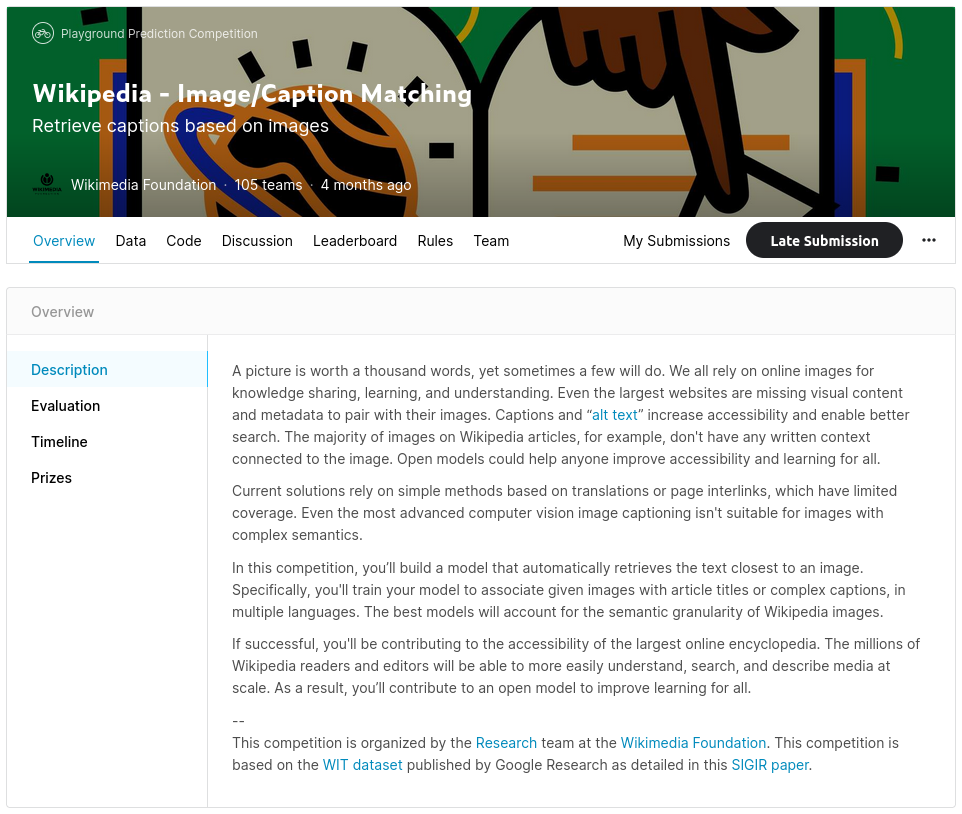


---

Quelle: [Wikipedia -Image/Caption Matching Competition](https://www.kaggle.com/competitions/wikipedia-image-caption)

### Setup und Kaggle Authentifizierung

In [ ]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle # force install the latest version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=569e7713e4f0bb2ac52f4fb7ebb670096008588bd7bf3c1a301907bee3b2df5e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


### Setup

In [ ]:
############################
#Imports
############################
import os
from pathlib import Path
from tqdm.auto import tqdm
import gc
from os import cpu_count
from google.colab import files

#Bilder und Plotting
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

#Bilder laden
import uuid
from urllib import request
from urllib.request import urlopen


import pandas as pd
import numpy as np

In [ ]:
#Globals
DATASET_PATH = './'
D_NAME = 'https://upload.wikimedia.org'
IMAGE_DIR = './images/'

Authentifizierung mit dem Kaggle API token(kaggle.json) [Anleitung](https://www.kaggle.com/docs/api)

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


### Hilfsfunktion

In [ ]:
def load_image(link):
    """
    Laden des Bildes aus dem übergebenen Link und Ausgabe als PIL Image
    """
    try:
        URL = link#.rsplit(';', 1)[1]
        filename = str(uuid.uuid4())
        path = f'./images/{filename}'
        req = request.Request(URL)
        req.add_header('User-Agent', 'User-bot-abc')#,'Connection', 'close')
        response = request.urlopen(req)
        
        with open(path, 'wb') as f:
            f.write(response.read())
        
        image = Image.open(path).convert("RGB")
        
        os.remove(path)
        
        return image
    
    except Exception as e:
        print(e)
        return None

### Überblick über die Datensätze

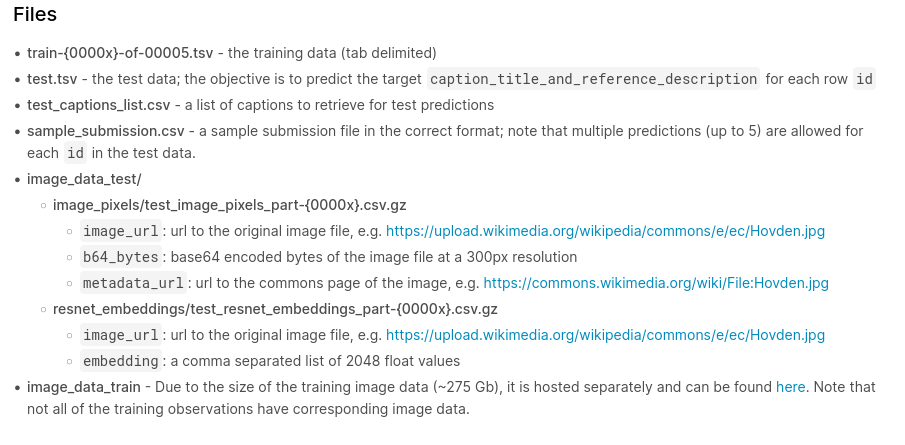

Quelle: [Wikipedia -Image/Caption Matching Competition Data](https://www.kaggle.com/competitions/wikipedia-image-caption/data)

Die bereitgestellten Datensätze lassen sich in zwei Bereiche einteilen. Einerseits in Trainingsdaten und andererseits Testdaten, die für das Ranking der Competition wichtig sind. Innerhalb der Trainingsdaten sind vor allem die Bilder und die sogenannte caption_title_and_reference_description besonders wichtig.
Auch zu sehen ist, dass durch die Bilder der Datensatz mit 275 GB sehr groß ist.

## 2. Downloaden und Speichern des preprocessed Datensatzes

Wie oben erwähnt, wurde das Preprocessing der originalen Trainigsdaten auf dieses [Kaggle-Notebook](https://www.kaggle.com/code/martenro/fork-of-preprocessedcaptionwikifeatherformat/notebook?scriptVersionId=92647710) ausgelagert. Dabei wurden alle Bilder-Urls, die nicht abrufbar waren aus dem Datensatz entfernt. Außerdem wurde der Trennungstoken [SEP], der in den Captions vorhanden war durch einen xlm-roberta Token ersetzt. Dies ist wichtig für die spätere Verwendung im multilingualen Modell.  


In [ ]:
#Erstellen der data und images Directories
Path('./trainingdata').mkdir(exist_ok=True)
Path('./images').mkdir(exist_ok=True)

In [ ]:
!kaggle kernels output martenro/fork-of-preprocessedcaptionwikifeatherformat -p trainingdata

Output file downloaded to trainingdata/test
Output file downloaded to trainingdata/test_caption_list
Output file downloaded to trainingdata/train-00000-of-00005
Output file downloaded to trainingdata/train-00001-of-00005
Output file downloaded to trainingdata/train-00002-of-00005
Output file downloaded to trainingdata/train-00003-of-00005
Output file downloaded to trainingdata/train-00004-of-00005
Output file downloaded to trainingdata/wiki_test.csv
Output file downloaded to trainingdata/wiki_test_caption_list.csv
Output file downloaded to trainingdata/wikidata.csv
Kernel log downloaded to trainingdata/fork-of-preprocessedcaptionwikifeatherformat.log 


In [ ]:
!ls trainingdata

fork-of-preprocessedcaptionwikifeatherformat.log  train-00003-of-00005
test						  train-00004-of-00005
test_caption_list				  wikidata.csv
train-00000-of-00005				  wiki_test_caption_list.csv
train-00001-of-00005				  wiki_test.csv
train-00002-of-00005


In [ ]:
df_wiki = pd.read_csv('./trainingdata/wikidata.csv')

In [ ]:
df_wiki.describe()

,language,page_url,image_url,page_title,section_title,hierarchical_section_title,caption_reference_description,caption_attribution_description,caption_alt_text_description,mime_type,original_height,original_width,is_main_image,attribution_passes_lang_id,page_changed_recently,context_page_description,context_section_description,caption_title_and_reference_description
count,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776,11776
unique,94,9043,9961,8496,6764,10413,11443,9896,10663,7,2697,3140,7,4,2,9037,10202,11622
top,en,https://en.wikipedia.org/wiki/List_of_New_York...,http://upload.wikimedia.org/wikipedia/commons/...,List of New York State Historic Markers in Uls...,South Georgia and the South Sandwich Islands,List of New York State Historic Markers in Uls...,Weitere Bilder,English: Map of South Georgia for pin Geograph...,A.,image/jpeg,799,1119,false,true,False,This is an incomplete list of New York State H...,(147 Markers),Liste der Kulturdenkmale in Quedlinburg </s> W...
freq,3335,104,492,104,281,104,29,492,94,9740,496,495,11367,6515,7394,104,104,10


#### Trainingsdaten
Die Trainingsdaten bestehen aus 11776 Dateneinträgen. Dabei setzen sich die Captions aus 94 unterschiedlichen Sprachen zusammen. Dies ist für die Bearbeitung der Competition eine Herausforderung, das CLIP-Modell von Openai nur auf Englisch trainiert wurde und die meisten multilingualen NLP-Transformer nicht auf eine so große Anzahl an Sprachen ausgerichtet sind. Deswegen ist es notwendig ein eigenes Modell zu erstellen.

Wie unten im Header zu sehen und wie aus der Competition-Beschreibung hervorgeht, sind die zwei wichtigsten Spalten für die Bearbeitung der Competition und für das Trainieren des Modells 'image_url' und 'caption_title_and_reference_description'.

In [ ]:
df_wiki.head()

,language,page_url,image_url,page_title,section_title,hierarchical_section_title,caption_reference_description,caption_attribution_description,caption_alt_text_description,mime_type,original_height,original_width,is_main_image,attribution_passes_lang_id,page_changed_recently,context_page_description,context_section_description,caption_title_and_reference_description
0,vi,https://vi.wikipedia.org/wiki/Gi%C3%A0y_cao_g%...,https://upload.wikimedia.org/wikipedia/commons...,Giày cao gót,Trước những năm 1700,Giày cao gót / Lịch sử / Trước những năm 1700,"Giày cao gót châu Âu, khoảng 1690",European; Shoes;,European heeled shoes from ca. 1690,image/jpeg,2166,4000,false,false,True,Giày cao gót là một loại giày trong đó gót châ...,"Giày cao gót có một lịch sử lâu đời, có niên đ...","Giày cao gót </s> Giày cao gót châu Âu, khoảng..."
1,fr,https://fr.wikipedia.org/wiki/Grand_Prix_autom...,https://upload.wikimedia.org/wikipedia/commons...,Grand Prix automobile de France 1957,Le championnat du monde,Grand Prix automobile de France 1957 / Context...,Juan Manuel Fangio et sa Maserati 250F : la co...,English: Fangio with spectators in the pits at...,Fangio en 1957,image/jpeg,768,509,false,false,True,"Le Grand Prix de France 1957, disputé sur le c...",La saison 1957 est la quatrième se disputant s...,Grand Prix automobile de France 1957 </s> Juan...
2,zh-TW,https://zh.wikipedia.org/zh-tw/%E9%81%93%E8%B0...,https://upload.wikimedia.org/wikipedia/commons...,道谷站,首爾交通公社,道谷站 / 車站結構 / 首爾交通公社,車站月台,日本語: 道谷駅ホーム（ソウル地下鉄3号線）한국어: 도곡역(서울 지하철 3호선) 승강장...,車站月台,image/jpeg,2250,4000,true,true,False,道谷站是一個位於首爾特別市江南區道谷洞，屬於首爾地鐵3號線與盆唐線的轉乘站。,2面2線對向式月台，設有月台幕門。本線軌道中間分隔得很開，看起來就像設有留置線，實際上是大峙...,道谷站 </s> 車站月台
3,zh-TW,https://zh.wikipedia.org/wiki/%E5%8C%97%E4%BB%...,https://upload.wikimedia.org/wikipedia/commons...,北仙台站,JR東日本,北仙台站 / 車站結構 / JR東日本,月台,日本語: 北仙台駅（仙山線）ホーム한국어: 기타센다이 역(센잔 선) 승강장 모습Engl...,月台,image/jpeg,2112,2816,true,false,False,北仙台站是一個位於日本宮城縣仙台市青葉區昭和町，屬於仙山線、仙台市地下鐵南北線的鐵路車站。仙...,島式月台1面2線的地面車站，2號月台與本線是1線貫通構造。月台、大堂位於1樓是地面車站，軌道...,北仙台站 </s> 月台
4,en,https://en.wikipedia.org/wiki/Silver_spoon,https://upload.wikimedia.org/wikipedia/commons...,Silver spoon,Historical uses,Silver spoon / Historical uses,Two silver-gilt strainer spoons and a cignus s...,English: Two silver strainer spoons and a silv...,"three spoons, two with holes, one with a curve...",image/jpeg,1194,2139,false,true,True,"""The English language expression silver spoon ...",Before the place setting became popular around...,Silver spoon </s> Two silver-gilt strainer spo...


In [ ]:
#Die wichtigen zwei Spalten behalten
df_wiki_lang = pd.DataFrame(df_wiki, columns = ['language', 'image_url','caption_title_and_reference_description'])

df_wiki_relevant = pd.DataFrame(df_wiki, columns = ['image_url','caption_title_and_reference_description'])
df_wiki_relevant

,image_url,caption_title_and_reference_description
0,https://upload.wikimedia.org/wikipedia/commons...,"Giày cao gót </s> Giày cao gót châu Âu, khoảng..."
1,https://upload.wikimedia.org/wikipedia/commons...,Grand Prix automobile de France 1957 </s> Juan...
2,https://upload.wikimedia.org/wikipedia/commons...,道谷站 </s> 車站月台
3,https://upload.wikimedia.org/wikipedia/commons...,北仙台站 </s> 月台
4,https://upload.wikimedia.org/wikipedia/commons...,Silver spoon </s> Two silver-gilt strainer spo...
...,...,...
11771,https://upload.wikimedia.org/wikipedia/commons...,Renault R23 </s> La Renault R23 de Jarno Trull...
11772,https://upload.wikimedia.org/wikipedia/commons...,Chanson des quatre fils Aymon </s> Vue des rui...
11773,https://upload.wikimedia.org/wikipedia/commons...,Дуньхуанская карта </s> Китайский Дуньхуанский...
11774,http://upload.wikimedia.org/wikipedia/commons/...,Géorgiques </s> Le jardin du vieillard corycie...


## 3. Datenvisualisierung

Im Nachfolgenden soll verdeutlicht werden, welche Sprachverteilung im Datensatz vorliegt.

In [ ]:
#Sprachverteilung im Datensatz
fig = px.histogram(df_wiki, x='language', template='plotly_white', title='Anzahl der Sprachen')
fig.update_xaxes(categoryorder='total descending').update_yaxes(title='Anzahl an Captions')
fig.show()

In [ ]:
#Die 5 häufigsten Sprachen genauer betrachten
dfg = df_wiki.groupby(['language']).size().to_frame().sort_values([0], ascending = False).head(5).reset_index()
dfg.columns = ['language', 'count']
fig = px.histogram(dfg, x='language', y = 'count')
fig.layout.yaxis.title.text = 'count'
fig.show()

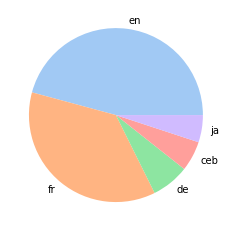

In [ ]:
top_five = df_wiki.groupby(['language']).size().to_frame().sort_values([0], ascending = False).head(5).reset_index()
per_cap = top_five.iloc[:,1]
language = top_five.language.tolist()

colors = sns.color_palette('pastel')
plt.pie(per_cap, labels = language, colors = colors)
plt.show()

In [ ]:
unsorted_lengths = [len(x) for x in df_wiki.caption_title_and_reference_description]

Wie aus den Visualisierungen hervorgeht, ist die Verteilung der 94 Sprachen sehr unterschiedlich. Ein Großteil der Captions ist in englischer Sprache. Der zweitgrößte Anteil ist französisch und zusammen machen diese Captions deutlich mehr als die Hälfte des Datensatzes aus.
</br>
</br>
Ein weiterer wichtiger Punkt, der beachtet werden muss, ist die Länge der einzelnen Captions. Das CLIP-Modell hat eine maximale Content Length von 77 Zeichen. Da der Großteil der Captions eine Länge von ca. 150 Zeichen hat wie unten zu sehen, könnte dies Auswirkungen auf die Genauigkeit des Ausgangsmodells haben.

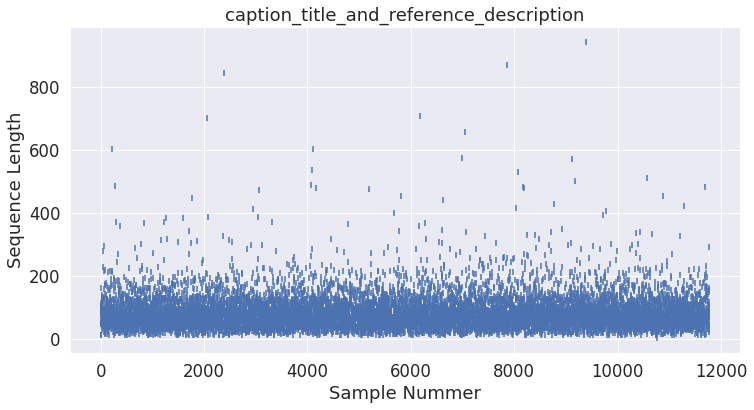

In [ ]:
#länge von captions(CLIP max_length ist 77 Zeichen)
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Nummer')
plt.ylabel('Sequence Length')
plt.title('caption_title_and_reference_description')

plt.show()

### Bild und Caption Beispiele

Um einen besseren Einblick in die Daten zu erhalten, sind im Folgenden Bild-Caption Paare der fünf häufigsten Sprachen dargestellt. Diese Beispiele werden in den nächsten Notebooks vor der eigentlichen Evaluation der Modelle für eine beispielhafte Zuweisung durch eine Cosine-Similarity Matrix herangezogen.

In [ ]:
#Fünf häufigste Sprachen heraussuchen
lang_en_l = df_wiki[df_wiki.language == 'en'].iloc[0]
lang_fr_l = df_wiki[df_wiki.language == 'fr'].iloc[0]
lang_de_l = df_wiki[df_wiki.language == 'de'].iloc[0]
lang_ceb_l = df_wiki[df_wiki.language == 'ceb'].iloc[0]
lang_ja_l = df_wiki[df_wiki.language == 'ja'].iloc[0]

Caption:  Silver spoon </s> Two silver-gilt strainer spoons and a cignus spoon decorated with a mythical marine creature. (4th century AD Roman spoons from the Hoxne Hoard.)
Sprache:  en


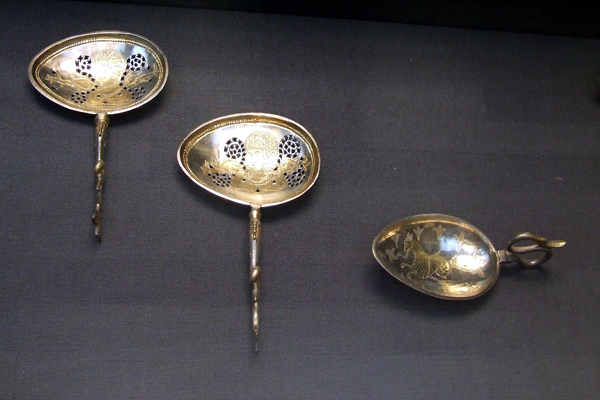

In [ ]:
#image + caption
print('Caption: ', lang_en_l.caption_title_and_reference_description)
print("Sprache: ", lang_en_l.language)
img = load_image(lang_en_l.image_url)
img.resize((600, 400))

Caption:  Grand Prix automobile de France 1957 </s> Juan Manuel Fangio et sa Maserati 250F : la combinaison à battre en 1957.
Sprache:  fr


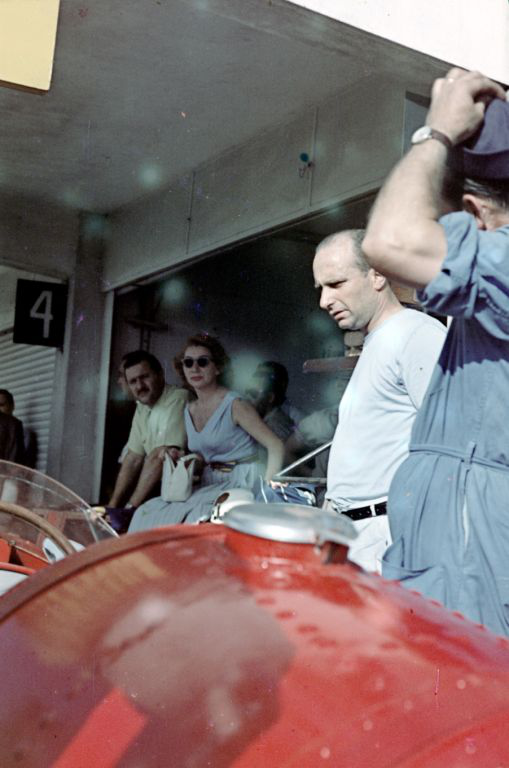

In [ ]:
#image + caption
print('Caption: ', lang_fr_l.caption_title_and_reference_description)
print("Sprache: ", lang_fr_l.language)
img = load_image(lang_fr_l.image_url)
img

Caption:  Ninestar </s> Ninestar G&G Druckerpatronen in einer Berliner Karstadt Filiale.
Sprache:  de


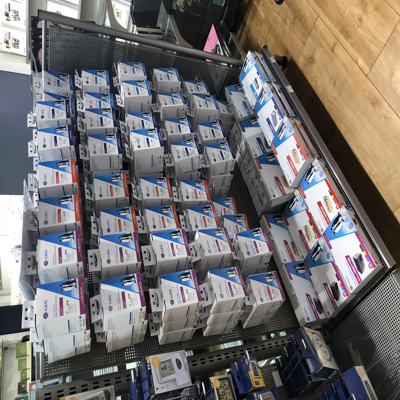

In [ ]:
#image + caption
print('Caption: ', lang_de_l.caption_title_and_reference_description)
print("Sprache: ", lang_de_l.language)
img = load_image(lang_de_l.image_url)
img.resize((400, 400))

Caption:  Johnson Point </s> Mga dapit nga gitawag Johnson Point sa South Georgia and the South Sandwich Islands (Hiniusang Gingharian).
Sprache:  ceb


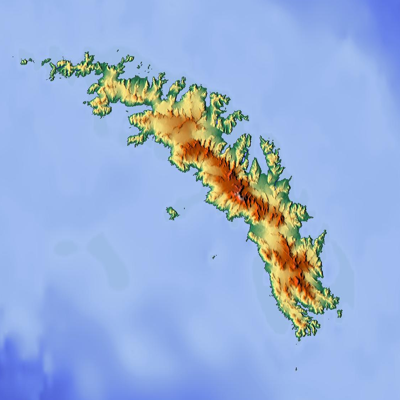

In [ ]:
#image + caption
print('Caption: ', lang_ceb_l.caption_title_and_reference_description)
print("Sprache: ", lang_ceb_l.language)
img = load_image(lang_ceb_l.image_url)
img.resize((400, 400))

Caption:  国営ひたち海浜公園 </s> 観覧車「プリンセスフラワー」
Sprache:  ja


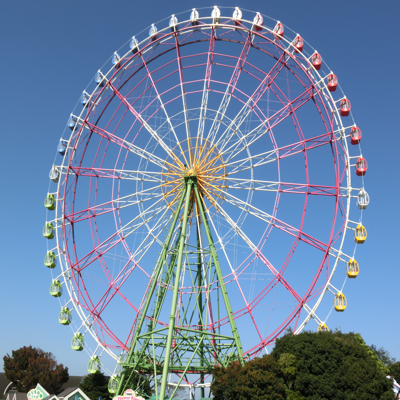

In [ ]:
#image + caption
print('Caption: ', lang_ja_l.caption_title_and_reference_description)
print("Sprache: ", lang_ja_l.language)
img = load_image(lang_ja_l.image_url)
img.resize((400, 400))

##  Competition Ranking - Daten

Die nur für das Ranking wichtigen Testdaten bestehen aus Bild-Urls mit zugehörigem id und caption_title_and_reference_description, die diesen Urls zugeordnet werden müssen.

In [ ]:
df_wiki_test = pd.read_csv('./trainingdata/wiki_test.csv')
wiki_test_caption_list = pd.read_csv('./trainingdata/wiki_test_caption_list.csv')

In [ ]:
df_wiki_test.head()

,id,image_url
0,0,https://upload.wikimedia.org/wikipedia/commons...
1,1,https://upload.wikimedia.org/wikipedia/commons...
2,2,https://upload.wikimedia.org/wikipedia/commons...
3,3,https://upload.wikimedia.org/wikipedia/commons...
4,4,https://upload.wikimedia.org/wikipedia/commons...


In [ ]:
wiki_test_caption_list.head()

,caption_title_and_reference_description
0,Albert Pike [SEP] Albert Pike
1,"""Anna Blount [SEP] Blount and her young daught..."
2,"""Río Marañón [SEP] Die Río Marañón in die Huán..."
3,"""Leonel Brizola [SEP] Brizola during his inaug..."
4,Buttisholz [SEP] Buttisholz


[Nächstes Colab(Benchmark)](https://colab.research.google.com/drive/1wLefrr7n329jjH4XGHPOtYW67-5T-Ufm?hl=de#scrollTo=5vyWvcALCDh-)